In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11329242360032642403, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9234857329
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11362655971247524259
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [3]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, partial, rand, space_eval
from sklearn.metrics import log_loss
import sys
import time
import math
import os
import pandas as pd
from keras.callbacks import EarlyStopping
import numpy as np
from glob import glob
import cv2
import skimage
from skimage.transform import resize
from keras.utils.np_utils import to_categorical
import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.models import load_model
# import keras.callbacks as kcall
from keras.optimizers import Adam, RMSprop,SGD
from keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
# from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.regularizers import l2, l1

from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score

import matplotlib.pyplot as plt
from keras.layers import Input, concatenate
from keras import optimizers, metrics, models
from keras.layers import Input, Flatten, Dense

%matplotlib inline

Using TensorFlow backend.


In [4]:
import keras
import tensorflow as tf

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
# print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.10.0


In [5]:
# print(os.listdir(""))

In [6]:
batch_size = 512
img_height, img_width = 128, 128
input_shape = (img_height, img_width, 3)
epochs = 1000

In [7]:
train_dir = 'data/train/'
test_dir = 'data/test'

In [8]:
def preprocess_input(x):
    # 'RGB'->'BGR'
    x = x[:, :, ::-1]
    # Zero-center by imagenet mean pixel
    x[:, :, 0] -= 103.939
    x[:, :, 1] -= 116.779
    x[:, :, 2] -= 123.68
    return x

In [9]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
#     featurewise_center=True,
#     featurewise_std_normalization=True,
    preprocessing_function = preprocess_input,
    validation_split= 0.2,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255, preprocessing_function = preprocess_input)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 319152 images belonging to 6 classes.
Found 79784 images belonging to 6 classes.
Found 13578 images belonging to 6 classes.


In [10]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
nb_test_samples = len(test_generator.filenames)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("nb_test_samples:", nb_test_samples)

print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 319152
nb_validation_samples: 79784
nb_test_samples: 13578

predict_size_train: 624
predict_size_validation: 156
predict_size_test: 27

 num_classes: 6


In [11]:
# os.mkdir("extracted_features")
extracted_features_dir = "extracted_features/"
model_name = "InceptionResNetV2"

In [12]:
# vgg19_weights ="../input/full-keras-pretrained-no-top/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5"
# inception_weights ="../input/full-keras-pretrained-no-top//inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
# vgg16_weights ="../input/full-keras-pretrained-no-top/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
# denseNet201_weights ="../input/full-keras-pretrained-no-top/densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5"
# denseNet121_weights ="../input/full-keras-pretrained-no-top/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5"
# resenet50_weights ="../input/full-keras-pretrained-no-top/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
# inception_resnet_v2_weights ="../input/full-keras-pretrained-no-top/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5"
# nasnet_weights ="../input/full-keras-pretrained-no-top/nasnet_large_no_top.h5"
# nasnet_mobile_weights ="../input/full-keras-pretrained-no-top/nasnet_mobile_no_top.h5"
# mobilenet_weights ="../input/full-keras-pretrained-no-top/mobilenet_1_0_224_tf_no_top.h5"
# xception_weights = "../input/full-keras-pretrained-no-top/xception_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [14]:
# from keras.applications.vgg19 import VGG19
# from keras.applications.inception_v3 import InceptionV3
# from keras.applications.vgg16 import VGG16
# from keras.applications.xception import Xception, preprocess_input
# from keras.applications import DenseNet201
# from keras.applications import DenseNet121
# from keras.applications import ResNet50
from keras.applications.inception_resnet_v2 import InceptionResNetV2
# from keras.applications import NASNetLarge, NASNetMobile
# from keras.applications import MobileNet

In [15]:
# input_tensor = Input(shape = input_shape)  

# base_model1=InceptionV3(input_shape= input_shape,weights=inception_weights, include_top=False, input_tensor=input_tensor)
# base_model2=Xception(input_shape= input_shape,weights=xception_weights, include_top=False, input_tensor=input_tensor)

# x1 = base_model1.output
# x1 = GlobalAveragePooling2D()(x1)

# x2 = base_model2.output
# x2 = GlobalAveragePooling2D()(x2)

# merge = concatenate([x1, x2])
# predictions = Dense(num_classes, activation='softmax')(merge)

# model = Model(inputs=input_tensor,outputs=predictions)

In [16]:
# for i, layer in enumerate(model.layers):
#     print(i, layer.name)

In [17]:
# c1 = model.layers[11].output 
# c1 = GlobalAveragePooling2D()(c1)       

# c2 = model.layers[21].output
# c2 = GlobalAveragePooling2D()(c2)       

# c3 = model.layers[28].output
# c3 = GlobalAveragePooling2D()(c3)       

# c4 = model.layers[51].output
# c4 = GlobalAveragePooling2D()(c4) 

# c5 = model.layers[84].output
# c5 = GlobalAveragePooling2D()(c5) 

# c6 = model.layers[103].output
# c6 = GlobalAveragePooling2D()(c6) 

# c7 = model.layers[117].output
# c7 = GlobalAveragePooling2D()(c7) 

# c8 = model.layers[129].output
# c8 = GlobalAveragePooling2D()(c8) 

# c9 = model.layers[143].output
# c9 = GlobalAveragePooling2D()(c9) 

# c10 = model.layers[162].output
# c10 = GlobalAveragePooling2D()(c10) 

# c11 = model.layers[210].output
# c11 = GlobalAveragePooling2D()(c11) 

# c12 = model.layers[258].output
# c12 = GlobalAveragePooling2D()(c12) 

# c13 = model.layers[306].output
# c13 = GlobalAveragePooling2D()(c13) 

# c14 = model.layers[356].output
# c14 = GlobalAveragePooling2D()(c14) 

# c15 = model.layers[377].output
# c15 = GlobalAveragePooling2D()(c15) 

# c16 = model.layers[415].output
# c16 = GlobalAveragePooling2D()(c16) 

# c17 = model.layers[421].output
# c17 = GlobalAveragePooling2D()(c17) 

# con = concatenate([c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, c14, c15, c16])

# bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [18]:
model = InceptionResNetV2(weights="imagenet", include_top=False, pooling = 'avg', input_tensor=Input(shape=input_shape))

In [19]:
bottleneck_final_model = model

In [20]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train, max_q_size=1, pickle_safe=False)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [21]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

In [22]:
bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [23]:
# import tensorflow as tf
# from keras.backend.tensorflow_backend import get_session
# from keras.backend.tensorflow_backend import clear_session
# from keras.backend.tensorflow_backend import set_session

# def reset_keras_tf_session():
#     """
#     this function clears the gpu memory and set the 
#     tf session to not use the whole gpu
#     """
#     sess = get_session()
#     clear_session()
#     sess.close()
#     sess = get_session()

# #     config = tf.ConfigProto()
# #     config.gpu_options.allow_growth = True
# #     set_session(tf.Session(config=config))

# reset_keras_tf_session()

In [24]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [25]:
# dropout_rate = 0.5

model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(2048, activation="softplus", kernel_regularizer=l2(1e-05), bias_regularizer=l2(0.0001), activity_regularizer=l1(1e-07)))
model.add(Dropout(0.25))

model.add(Dense(256, activation="softplus", kernel_regularizer=l2(1e-05), bias_regularizer=l2(0.0001), activity_regularizer=l1(1e-07)))
model.add(Dropout(0.5))
    
model.add(Dense(num_classes, activation="softmax"))

adam_opt=Adam(lr = 0.0001, beta_1=0.8, beta_2=0.99)

model.compile(optimizer=adam_opt, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=1000,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

# model.save_weights(top_model_weights_path)
# model.save(top_model_path)

Train on 319152 samples, validate on 79784 samples
Epoch 1/1000
 - 9s - loss: 0.8458 - acc: 0.7166 - val_loss: 0.6300 - val_acc: 0.8008
Epoch 2/1000
 - 6s - loss: 0.5971 - acc: 0.8036 - val_loss: 0.5408 - val_acc: 0.8329
Epoch 3/1000
 - 6s - loss: 0.5327 - acc: 0.8258 - val_loss: 0.5003 - val_acc: 0.8446
Epoch 4/1000
 - 6s - loss: 0.5008 - acc: 0.8367 - val_loss: 0.4749 - val_acc: 0.8485
Epoch 5/1000
 - 6s - loss: 0.4799 - acc: 0.8444 - val_loss: 0.4601 - val_acc: 0.8547
Epoch 6/1000
 - 6s - loss: 0.4636 - acc: 0.8506 - val_loss: 0.4471 - val_acc: 0.8584
Epoch 7/1000
 - 6s - loss: 0.4518 - acc: 0.8547 - val_loss: 0.4339 - val_acc: 0.8662
Epoch 8/1000
 - 6s - loss: 0.4408 - acc: 0.8584 - val_loss: 0.4232 - val_acc: 0.8676
Epoch 9/1000
 - 6s - loss: 0.4329 - acc: 0.8608 - val_loss: 0.4228 - val_acc: 0.8679
Epoch 10/1000
 - 6s - loss: 0.4259 - acc: 0.8639 - val_loss: 0.4132 - val_acc: 0.8755
Epoch 11/1000
 - 6s - loss: 0.4191 - acc: 0.8661 - val_loss: 0.4058 - val_acc: 0.8755
Epoch 12/100

Epoch 96/1000
 - 6s - loss: 0.3265 - acc: 0.9045 - val_loss: 0.3238 - val_acc: 0.9091
Epoch 97/1000
 - 6s - loss: 0.3263 - acc: 0.9047 - val_loss: 0.3258 - val_acc: 0.9081
Epoch 98/1000
 - 6s - loss: 0.3262 - acc: 0.9042 - val_loss: 0.3231 - val_acc: 0.9090
Epoch 99/1000
 - 6s - loss: 0.3262 - acc: 0.9047 - val_loss: 0.3223 - val_acc: 0.9104
Epoch 100/1000
 - 6s - loss: 0.3259 - acc: 0.9045 - val_loss: 0.3226 - val_acc: 0.9102
Epoch 101/1000
 - 6s - loss: 0.3248 - acc: 0.9054 - val_loss: 0.3222 - val_acc: 0.9090
Epoch 102/1000
 - 6s - loss: 0.3251 - acc: 0.9055 - val_loss: 0.3229 - val_acc: 0.9092
Epoch 103/1000
 - 6s - loss: 0.3247 - acc: 0.9052 - val_loss: 0.3213 - val_acc: 0.9103
Epoch 104/1000
 - 6s - loss: 0.3241 - acc: 0.9054 - val_loss: 0.3231 - val_acc: 0.9092
Epoch 105/1000
 - 6s - loss: 0.3235 - acc: 0.9056 - val_loss: 0.3226 - val_acc: 0.9090
Epoch 106/1000
 - 6s - loss: 0.3245 - acc: 0.9054 - val_loss: 0.3220 - val_acc: 0.9109
Epoch 107/1000
 - 6s - loss: 0.3240 - acc: 0.90

Epoch 191/1000
 - 6s - loss: 0.3120 - acc: 0.9119 - val_loss: 0.3142 - val_acc: 0.9158
Epoch 192/1000
 - 6s - loss: 0.3125 - acc: 0.9117 - val_loss: 0.3141 - val_acc: 0.9143
Epoch 193/1000
 - 6s - loss: 0.3119 - acc: 0.9119 - val_loss: 0.3110 - val_acc: 0.9164
Epoch 194/1000
 - 6s - loss: 0.3114 - acc: 0.9123 - val_loss: 0.3124 - val_acc: 0.9151
Epoch 195/1000
 - 6s - loss: 0.3121 - acc: 0.9115 - val_loss: 0.3132 - val_acc: 0.9153
Epoch 196/1000
 - 6s - loss: 0.3113 - acc: 0.9121 - val_loss: 0.3107 - val_acc: 0.9156
Epoch 197/1000
 - 6s - loss: 0.3122 - acc: 0.9122 - val_loss: 0.3137 - val_acc: 0.9150
Epoch 198/1000
 - 6s - loss: 0.3112 - acc: 0.9120 - val_loss: 0.3150 - val_acc: 0.9135
Epoch 199/1000
 - 6s - loss: 0.3123 - acc: 0.9116 - val_loss: 0.3128 - val_acc: 0.9146
Epoch 200/1000
 - 6s - loss: 0.3121 - acc: 0.9122 - val_loss: 0.3127 - val_acc: 0.9158
Epoch 201/1000
 - 6s - loss: 0.3105 - acc: 0.9123 - val_loss: 0.3124 - val_acc: 0.9158
Epoch 202/1000
 - 6s - loss: 0.3111 - acc: 

 - 6s - loss: 0.3071 - acc: 0.9143 - val_loss: 0.3094 - val_acc: 0.9175
Epoch 286/1000
 - 6s - loss: 0.3052 - acc: 0.9157 - val_loss: 0.3071 - val_acc: 0.9187
Epoch 287/1000
 - 6s - loss: 0.3054 - acc: 0.9154 - val_loss: 0.3081 - val_acc: 0.9180
Epoch 288/1000
 - 6s - loss: 0.3056 - acc: 0.9151 - val_loss: 0.3124 - val_acc: 0.9144
Epoch 289/1000
 - 6s - loss: 0.3059 - acc: 0.9148 - val_loss: 0.3080 - val_acc: 0.9176
Epoch 290/1000
 - 6s - loss: 0.3060 - acc: 0.9147 - val_loss: 0.3108 - val_acc: 0.9177
Epoch 291/1000
 - 6s - loss: 0.3061 - acc: 0.9152 - val_loss: 0.3072 - val_acc: 0.9174
Epoch 292/1000
 - 6s - loss: 0.3059 - acc: 0.9156 - val_loss: 0.3072 - val_acc: 0.9182
Epoch 293/1000
 - 6s - loss: 0.3062 - acc: 0.9151 - val_loss: 0.3078 - val_acc: 0.9183
Epoch 294/1000
 - 6s - loss: 0.3061 - acc: 0.9151 - val_loss: 0.3097 - val_acc: 0.9179
Epoch 295/1000
 - 6s - loss: 0.3071 - acc: 0.9149 - val_loss: 0.3094 - val_acc: 0.9183
Epoch 296/1000
 - 6s - loss: 0.3060 - acc: 0.9150 - val_lo

Epoch 380/1000
 - 6s - loss: 0.3022 - acc: 0.9170 - val_loss: 0.3051 - val_acc: 0.9201
Epoch 381/1000
 - 6s - loss: 0.3027 - acc: 0.9170 - val_loss: 0.3075 - val_acc: 0.9194
Epoch 382/1000
 - 6s - loss: 0.3026 - acc: 0.9170 - val_loss: 0.3049 - val_acc: 0.9199
Epoch 383/1000
 - 6s - loss: 0.3017 - acc: 0.9172 - val_loss: 0.3060 - val_acc: 0.9194
Epoch 384/1000
 - 6s - loss: 0.3027 - acc: 0.9172 - val_loss: 0.3058 - val_acc: 0.9206
Epoch 385/1000
 - 6s - loss: 0.3028 - acc: 0.9171 - val_loss: 0.3060 - val_acc: 0.9200
Epoch 386/1000
 - 6s - loss: 0.3025 - acc: 0.9169 - val_loss: 0.3060 - val_acc: 0.9192
Epoch 387/1000
 - 6s - loss: 0.3024 - acc: 0.9169 - val_loss: 0.3040 - val_acc: 0.9192
Epoch 388/1000
 - 6s - loss: 0.3029 - acc: 0.9174 - val_loss: 0.3059 - val_acc: 0.9200
Epoch 389/1000
 - 6s - loss: 0.3025 - acc: 0.9171 - val_loss: 0.3050 - val_acc: 0.9200
Epoch 390/1000
 - 6s - loss: 0.3029 - acc: 0.9166 - val_loss: 0.3092 - val_acc: 0.9178
Epoch 391/1000
 - 6s - loss: 0.3023 - acc: 

 - 6s - loss: 0.3008 - acc: 0.9178 - val_loss: 0.3051 - val_acc: 0.9208
Epoch 475/1000
 - 6s - loss: 0.3005 - acc: 0.9183 - val_loss: 0.3044 - val_acc: 0.9207
Epoch 476/1000
 - 6s - loss: 0.3004 - acc: 0.9183 - val_loss: 0.3045 - val_acc: 0.9205
Epoch 477/1000
 - 6s - loss: 0.2998 - acc: 0.9182 - val_loss: 0.3043 - val_acc: 0.9203
Epoch 478/1000
 - 6s - loss: 0.3003 - acc: 0.9184 - val_loss: 0.3062 - val_acc: 0.9184
Epoch 479/1000
 - 6s - loss: 0.3011 - acc: 0.9180 - val_loss: 0.3037 - val_acc: 0.9213
Epoch 480/1000
 - 6s - loss: 0.2998 - acc: 0.9186 - val_loss: 0.3039 - val_acc: 0.9212
Epoch 481/1000
 - 6s - loss: 0.3009 - acc: 0.9181 - val_loss: 0.3041 - val_acc: 0.9209
Epoch 482/1000
 - 6s - loss: 0.3006 - acc: 0.9179 - val_loss: 0.3038 - val_acc: 0.9212
Epoch 483/1000
 - 6s - loss: 0.3005 - acc: 0.9180 - val_loss: 0.3031 - val_acc: 0.9205
Epoch 484/1000
 - 6s - loss: 0.3002 - acc: 0.9179 - val_loss: 0.3045 - val_acc: 0.9208
Epoch 485/1000
 - 6s - loss: 0.2999 - acc: 0.9185 - val_lo

Epoch 569/1000
 - 6s - loss: 0.2988 - acc: 0.9193 - val_loss: 0.3059 - val_acc: 0.9202
Epoch 570/1000
 - 6s - loss: 0.2985 - acc: 0.9190 - val_loss: 0.3034 - val_acc: 0.9199
Epoch 571/1000
 - 6s - loss: 0.2980 - acc: 0.9194 - val_loss: 0.3055 - val_acc: 0.9200
Epoch 572/1000
 - 6s - loss: 0.2991 - acc: 0.9191 - val_loss: 0.3030 - val_acc: 0.9212
Epoch 573/1000
 - 6s - loss: 0.2994 - acc: 0.9188 - val_loss: 0.3009 - val_acc: 0.9226
Epoch 574/1000
 - 6s - loss: 0.2990 - acc: 0.9190 - val_loss: 0.3042 - val_acc: 0.9211
Epoch 575/1000
 - 6s - loss: 0.2996 - acc: 0.9194 - val_loss: 0.3052 - val_acc: 0.9215
Epoch 576/1000
 - 6s - loss: 0.2978 - acc: 0.9199 - val_loss: 0.3051 - val_acc: 0.9195
Epoch 577/1000
 - 6s - loss: 0.2984 - acc: 0.9198 - val_loss: 0.3038 - val_acc: 0.9211
Epoch 578/1000
 - 6s - loss: 0.2980 - acc: 0.9195 - val_loss: 0.3012 - val_acc: 0.9219
Epoch 579/1000
 - 6s - loss: 0.2987 - acc: 0.9193 - val_loss: 0.3041 - val_acc: 0.9210
Epoch 580/1000
 - 6s - loss: 0.2994 - acc: 

 - 6s - loss: 0.2987 - acc: 0.9194 - val_loss: 0.3039 - val_acc: 0.9216
Epoch 664/1000
 - 6s - loss: 0.2983 - acc: 0.9189 - val_loss: 0.3017 - val_acc: 0.9222
Epoch 665/1000
 - 6s - loss: 0.2970 - acc: 0.9204 - val_loss: 0.3014 - val_acc: 0.9218
Epoch 666/1000
 - 6s - loss: 0.2985 - acc: 0.9199 - val_loss: 0.3020 - val_acc: 0.9225
Epoch 667/1000
 - 6s - loss: 0.2983 - acc: 0.9196 - val_loss: 0.3010 - val_acc: 0.9219
Epoch 668/1000
 - 6s - loss: 0.2986 - acc: 0.9196 - val_loss: 0.3055 - val_acc: 0.9211
Epoch 669/1000
 - 6s - loss: 0.2977 - acc: 0.9197 - val_loss: 0.3030 - val_acc: 0.9208
Epoch 670/1000
 - 6s - loss: 0.2979 - acc: 0.9201 - val_loss: 0.3022 - val_acc: 0.9220
Epoch 671/1000
 - 6s - loss: 0.2973 - acc: 0.9201 - val_loss: 0.3017 - val_acc: 0.9215
Epoch 672/1000
 - 6s - loss: 0.2981 - acc: 0.9198 - val_loss: 0.3025 - val_acc: 0.9221
Epoch 673/1000
 - 6s - loss: 0.2962 - acc: 0.9207 - val_loss: 0.3000 - val_acc: 0.9224
Epoch 674/1000
 - 6s - loss: 0.2971 - acc: 0.9201 - val_lo

Epoch 758/1000
 - 6s - loss: 0.2971 - acc: 0.9200 - val_loss: 0.3011 - val_acc: 0.9220
Epoch 759/1000
 - 6s - loss: 0.2969 - acc: 0.9200 - val_loss: 0.2985 - val_acc: 0.9231
Epoch 760/1000
 - 6s - loss: 0.2961 - acc: 0.9204 - val_loss: 0.3014 - val_acc: 0.9225
Epoch 761/1000
 - 6s - loss: 0.2964 - acc: 0.9208 - val_loss: 0.3002 - val_acc: 0.9228
Epoch 762/1000
 - 6s - loss: 0.2968 - acc: 0.9204 - val_loss: 0.3018 - val_acc: 0.9226
Epoch 763/1000
 - 6s - loss: 0.2965 - acc: 0.9207 - val_loss: 0.3016 - val_acc: 0.9225
Epoch 764/1000
 - 6s - loss: 0.2968 - acc: 0.9197 - val_loss: 0.3035 - val_acc: 0.9222
Epoch 765/1000
 - 6s - loss: 0.2968 - acc: 0.9203 - val_loss: 0.3026 - val_acc: 0.9220
Epoch 766/1000
 - 6s - loss: 0.2963 - acc: 0.9204 - val_loss: 0.3003 - val_acc: 0.9226
Epoch 767/1000
 - 6s - loss: 0.2974 - acc: 0.9205 - val_loss: 0.3010 - val_acc: 0.9234
Epoch 768/1000
 - 6s - loss: 0.2967 - acc: 0.9198 - val_loss: 0.3013 - val_acc: 0.9223
Epoch 769/1000
 - 6s - loss: 0.2964 - acc: 

 - 6s - loss: 0.2968 - acc: 0.9203 - val_loss: 0.3011 - val_acc: 0.9228
Epoch 853/1000
 - 6s - loss: 0.2954 - acc: 0.9212 - val_loss: 0.3004 - val_acc: 0.9230
Epoch 854/1000
 - 6s - loss: 0.2968 - acc: 0.9201 - val_loss: 0.3001 - val_acc: 0.9224
Epoch 855/1000
 - 6s - loss: 0.2966 - acc: 0.9205 - val_loss: 0.3021 - val_acc: 0.9233
Epoch 856/1000
 - 6s - loss: 0.2952 - acc: 0.9213 - val_loss: 0.3021 - val_acc: 0.9225
Epoch 857/1000
 - 6s - loss: 0.2950 - acc: 0.9211 - val_loss: 0.3002 - val_acc: 0.9227
Epoch 858/1000
 - 6s - loss: 0.2962 - acc: 0.9208 - val_loss: 0.3006 - val_acc: 0.9230
Epoch 859/1000
 - 6s - loss: 0.2958 - acc: 0.9209 - val_loss: 0.3006 - val_acc: 0.9225
Epoch 860/1000
 - 6s - loss: 0.2961 - acc: 0.9210 - val_loss: 0.3010 - val_acc: 0.9222
Epoch 861/1000
 - 6s - loss: 0.2960 - acc: 0.9207 - val_loss: 0.3021 - val_acc: 0.9225
Epoch 862/1000
 - 6s - loss: 0.2968 - acc: 0.9205 - val_loss: 0.3014 - val_acc: 0.9225
Epoch 863/1000
 - 6s - loss: 0.2953 - acc: 0.9210 - val_lo

Epoch 947/1000
 - 6s - loss: 0.2957 - acc: 0.9214 - val_loss: 0.3013 - val_acc: 0.9233
Epoch 948/1000
 - 6s - loss: 0.2955 - acc: 0.9214 - val_loss: 0.3000 - val_acc: 0.9230
Epoch 949/1000
 - 6s - loss: 0.2961 - acc: 0.9212 - val_loss: 0.3030 - val_acc: 0.9219
Epoch 950/1000
 - 6s - loss: 0.2947 - acc: 0.9210 - val_loss: 0.3021 - val_acc: 0.9229
Epoch 951/1000
 - 6s - loss: 0.2961 - acc: 0.9208 - val_loss: 0.3030 - val_acc: 0.9231
Epoch 952/1000
 - 6s - loss: 0.2955 - acc: 0.9213 - val_loss: 0.3013 - val_acc: 0.9228
Epoch 953/1000
 - 6s - loss: 0.2949 - acc: 0.9211 - val_loss: 0.3006 - val_acc: 0.9225
Epoch 954/1000
 - 6s - loss: 0.2953 - acc: 0.9209 - val_loss: 0.3001 - val_acc: 0.9236
Epoch 955/1000
 - 6s - loss: 0.2947 - acc: 0.9209 - val_loss: 0.2998 - val_acc: 0.9235
Epoch 956/1000
 - 6s - loss: 0.2959 - acc: 0.9209 - val_loss: 0.3007 - val_acc: 0.9233
Epoch 957/1000
 - 6s - loss: 0.2952 - acc: 0.9209 - val_loss: 0.3002 - val_acc: 0.9237
Epoch 958/1000
 - 6s - loss: 0.2958 - acc: 

In [26]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.9085285019885109


Confusion Matrix
[[2790    5   10    3   53   65]
 [   5  433   12   17   40   12]
 [   5   10 2793   27   33  211]
 [   1   15   69  952   20   40]
 [  24   24   62   16 2636   67]
 [  76    7  220   32   61 2732]]


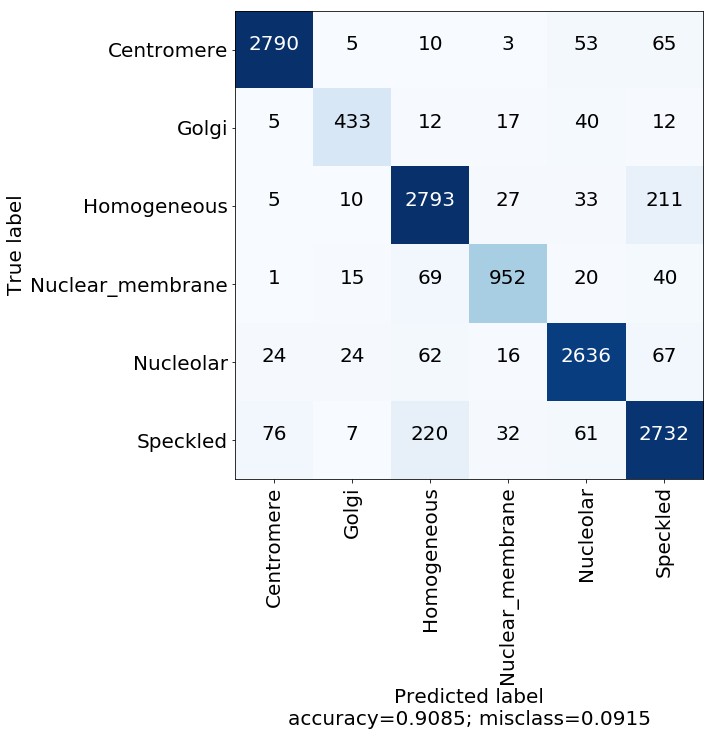

In [27]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [28]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[2790    5   10    3   53   65]
 [   5  433   12   17   40   12]
 [   5   10 2793   27   33  211]
 [   1   15   69  952   20   40]
 [  24   24   62   16 2636   67]
 [  76    7  220   32   61 2732]]
                  precision    recall  f1-score   support

      Centromere       0.96      0.95      0.96      2926
           Golgi       0.88      0.83      0.85       519
     Homogeneous       0.88      0.91      0.89      3079
Nuclear_membrane       0.91      0.87      0.89      1097
       Nucleolar       0.93      0.93      0.93      2829
        Speckled       0.87      0.87      0.87      3128

     avg / total       0.91      0.91      0.91     13578



In [29]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity )

Sensitivity :  0.998211091234347
Specificity :  0.9885844748858448


In [30]:
y_pred_class = model.predict(test_data, verbose=1)

y_pred_class = [np.argmax(r) for r in y_pred_class]
test_y = [np.argmax(r) for r in test_labels]


from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, roc_curve

# Precision
print('Precision = ', precision_score(test_y, y_pred_class, average='weighted'))
# (None, 'micro', 'macro', 'weighted', 'samples')

# Recall
print('Recall = ', recall_score(test_y, y_pred_class, average='weighted'))

# f1_score
print('f1_score = ', f1_score(test_y, y_pred_class, average='weighted'))

13578/13578 [==============================] - 1s 37us/step
Precision =  0.9087172253434596
Recall =  0.9085285019885109
f1_score =  0.9085195498864951


In [31]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def multiclass_roc_auc_score(y_test, y_pred, average="weighted"):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(y_test)

    truth = label_binarizer.transform(y_test)
    pred = label_binarizer.transform(y_pred)
    return roc_auc_score(truth, pred, average=average)
# roc_auc_score
print('roc_auc_score = ', multiclass_roc_auc_score(test_y, y_pred_class))

roc_auc_score =  0.9423564512920696


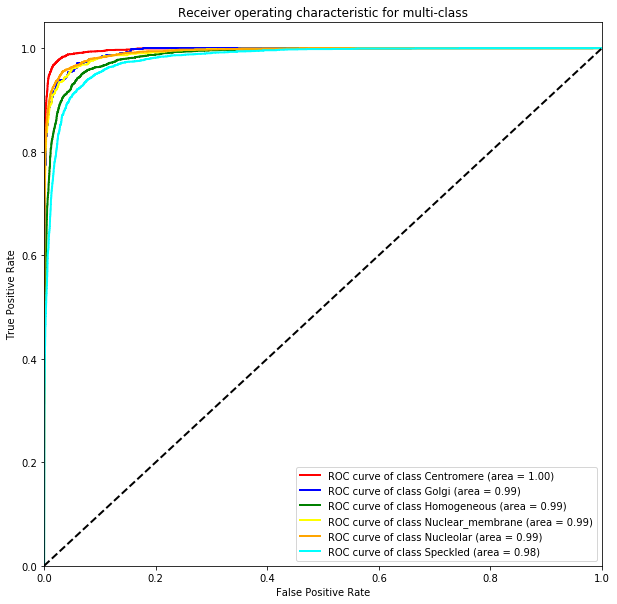

In [32]:
#ROC Curve for each class
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
%matplotlib inline  
from scipy import interp
from itertools import cycle

predict_class = np.argmax(preds, axis=1)

y_pred = preds
y_pred_probabilities=y_pred

y_pred = np.argmax(y_pred,axis = 1) 
y_actual = test_generator.classes

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

y_actual_binary = label_binarize(y_actual, classes=[0, 1, 2, 3, 4, 5])
y_pred_binary = y_pred_probabilities
n_classes=6
lw=2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_actual_binary[:, i], y_pred_binary[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_actual_binary.ravel(), y_pred_binary.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 10))


colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class')
plt.legend(loc="best")
plt.show()

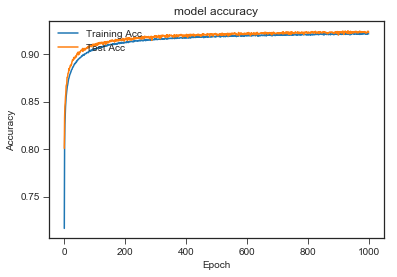

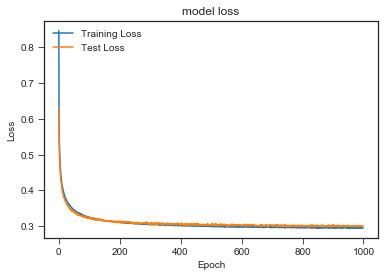

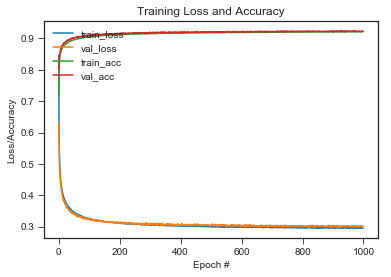

In [33]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")